In [11]:
import librosa  
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import noisereduce as nr
import fnmatch
from jupyterthemes import jtplot
import IPython.display as ipd
import sklearn

In [29]:
wavFolder = os.path.join("bird_data","wav_files")
mp3Folder = os.path.join("bird_data","mp3_files")
wavFiles = os.listdir(wavFolder)
mp3Files = os.listdir(mp3Folder)
example1 = os.path.join(wavFolder, wavFiles[3])
exampleFolder = os.path.join("bird_data","examples")

In [15]:
audioData = pd.read_csv(os.path.join("bird_data", "audioData_wav_.csv"))

In [16]:
audioData.head()

American_Goldfinch               American_Robin  \
0  American_Goldfinch_XC114342.wav  American_Robin_XC112597.wav   
1  American_Goldfinch_XC124312.wav  American_Robin_XC114082.wav   
2  American_Goldfinch_XC133564.wav  American_Robin_XC114083.wav   
3  American_Goldfinch_XC133565.wav  American_Robin_XC122037.wav   
4  American_Goldfinch_XC141469.wav  American_Robin_XC130246.wav   

                Barn_Swallow               Blue_Jay  \
0  Barn_Swallow_XC113501.wav  Blue_Jay_XC110056.wav   
1  Barn_Swallow_XC123032.wav  Blue_Jay_XC114085.wav   
2  Barn_Swallow_XC123035.wav  Blue_Jay_XC116372.wav   
3  Barn_Swallow_XC123036.wav  Blue_Jay_XC116373.wav   
4  Barn_Swallow_XC123066.wav  Blue_Jay_XC116374.wav   

                Blue-grey_Gnatcatcher               Carolina_Chickadee  \
0  Blue-grey_Gnatcatcher_XC130506.wav  Carolina_Chickadee_XC111140.wav   
1  Blue-grey_Gnatcatcher_XC130507.wav  Carolina_Chickadee_XC112508.wav   
2  Blue-grey_Gnatcatcher_XC130508.wav  Carolina_Chickadee_XC112509.wav   
3  Blue-grey_Gnatcatcher_XC130511.wav  Carolina_Chickadee_XC112510.wav   
4  Blue-grey_Gnatcatcher_XC130512.wav  Carolina_Chickadee_XC112633.wav   

                Carolina_Wren               Cedar_Waxwing  \
0  Carolina_Wren_XC112512.wav  Cedar_Waxwing_XC121795.wav   
1  Carolina_Wren_XC116314.wav  Cedar_Waxwing_XC121796.wav   
2  Carolina_Wren_XC122447.wav  Cedar_Waxwing_XC121797.wav   
3  Carolina_Wren_XC125657.wav  Cedar_Waxwing_XC121798.wav   
4  Carolina_Wren_XC125658.wav  Cedar_Waxwing_XC121799.wav   

                Northern_Cardinal               Ruby-crowned_Kinglet  
0  Northern_Cardinal_XC110059.wav  Ruby-crowned_Kinglet_XC131366.wav  
1  Northern_Cardinal_XC112830.wav  Ruby-crowned_Kinglet_XC131957.wav  
2  Northern_Cardinal_XC130962.wav  Ruby-crowned_Kinglet_XC138055.wav  
3  Northern_Cardinal_XC130966.wav  Ruby-crowned_Kinglet_XC156726.wav  
4  Northern_Cardinal_XC141210.wav  Ruby-crowned_Kinglet_XC159571.wav

In [83]:
birds_sample=[]
for bird in audioData.columns:
    temp = os.path.join(wavFolder, audioData[bird][3])
    birds_sample.append(temp)

# Audio Spectral Features


## Load Audio Signal Function

In [85]:
# Load signal and apply noise reduction if required
def loadSignal(file, downsample=True, denoise=False):
    SR = (22050 if downsample else 44100)
    max_duration=10
    signal, sr = librosa.load(file, sr=SR, mono=True, duration=max_duration)
    if denoise:
        rsignal = nr.reduce_noise(audio_clip=signal, noise_clip=signal, verbose=False)
        return rsignal, sr
    else:
        return signal, sr

## Spectrogram Functions

In [96]:
# Plot Raw signal
def RawSignal(FILE,PATH):
    destination_path = os.path.join(PATH, f'Mono_{FILE[20:-13]}.png')
    signal, sr = loadSignal(FILE, True, True)
    plt.figure(figsize=(10, 4), frameon=True)
    librosa.display.waveplot(signal, sr=sr)
    plt.title(f'Monophonic signal for {FILE[20:-13]}')
    plt.savefig(destination_path, bbox_inches = 'tight')
    plt.show()

In [97]:
# Linear-frequency power spectrogram
def Feq_Spectrogram(FILE, PATH):
    destination_path = os.path.join(PATH, f'Feq_{FILE[20:-13]}.png')
    signal, sr = loadSignal(FILE, True, True)
    normalized_signal = librosa.util.normalize(signal)
    spectra= librosa.amplitude_to_db(np.abs(librosa.stft(normalized_signal)), ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 4), frameon=True)
    img=librosa.display.specshow(spectra, y_axis='linear', x_axis='time')
    fig.colorbar(img, ax=ax)
    title = f'Linear-frequency power spectrogram for {FILE[20:-13]}'
    ax.set(title=title)
    fig.savefig(destination_path, bbox_inches = 'tight')
    plt.show() 

In [98]:
def Mel_Spectrogram(FILE, N_FFT, HOP_LENGTH, WINDOW, PATH, FILTER=False):
    if FILTER:
        FMIN = 1400
        destination_path=os.path.join(PATH, f'MEL_filter_{FILE[20:-13]}.png')
        title = ('Mel-scaled spectrogram with high-pass filter')
    else:
        FMIN = 0
        destination_path=os.path.join(PATH, f'MEL_{FILE[20:-13]}.png')
        title = ('Mel-scaled spectrogram')
        
    signal, sr = loadSignal(FILE, True, True)
    normalized_signal = librosa.util.normalize(signal)
    mel = librosa.feature.melspectrogram(y=normalized_signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                                         htk=True, window=WINDOW, fmin=FMIN, fmax=sr/2) 
    mel_normalized=librosa.util.normalize(mel)
    S_dB = librosa.power_to_db(mel_normalized**2,ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 4), frameon=True)
    librosa.display.specshow(S_dB, fmin=FMIN, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title+" for "+FILE[20:-13])
    fig.savefig(destination_path, bbox_inches = 'tight')
    plt.show()

In [99]:
# Mel-frequency cepstral coefficients (MFCCs)
def MFCC(FILE, N_FFT, N_MFCC, HOP_LENGTH, PATH, DCT=2, FILTER=False):
    if FILTER:
        LIFTER=2*N_MFCC
        destination_path=os.path.join(PATH, f'MFCC_filter_{FILE[20:-13]}.png')
        title = ('MFCC spectrogram with cepstral filtering')
    else:
        LIFTER = 0
        destination_path=os.path.join(PATH, f'MFCC_{FILE[20:-13]}.png')
        title = ('MFCC spectrogram')
  
    signal, sr = loadSignal(FILE, True, True)  
    normalized_signal = librosa.util.normalize(signal)
    mfccs = librosa.feature.mfcc(y=normalized_signal, sr=sr, n_fft = N_FFT, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, 
                                 htk=True, lifter=LIFTER, dct_type=DCT)
    normalized_mfccs = librosa.util.normalize(mfccs)
    fig, ax = plt.subplots(figsize=(10, 4), frameon=True)
    img = librosa.display.specshow(normalized_mfccs, x_axis='time', ax=ax)  
    fig.colorbar(img, ax=ax)
    title = ('MFCC with cepstral filtering' if FILTER else 'MFCC')
    ax.set(title=title+" for "+FILE[20:-13])
    fig.savefig(destination_path, bbox_inches='tight')
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

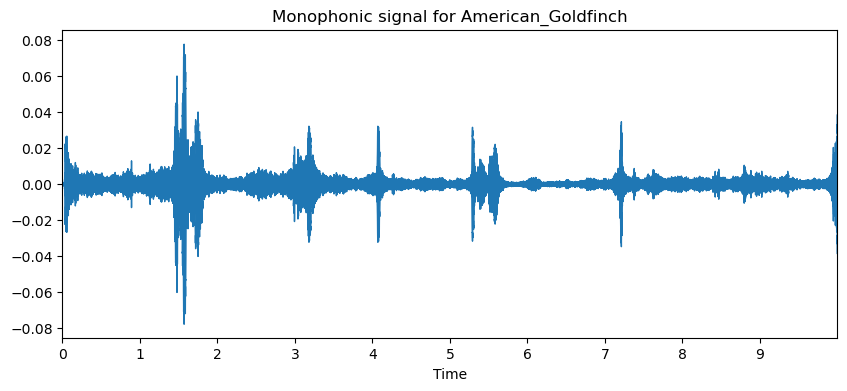

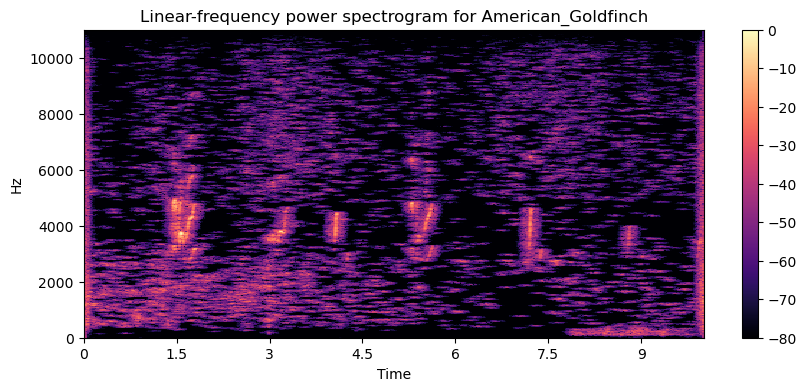

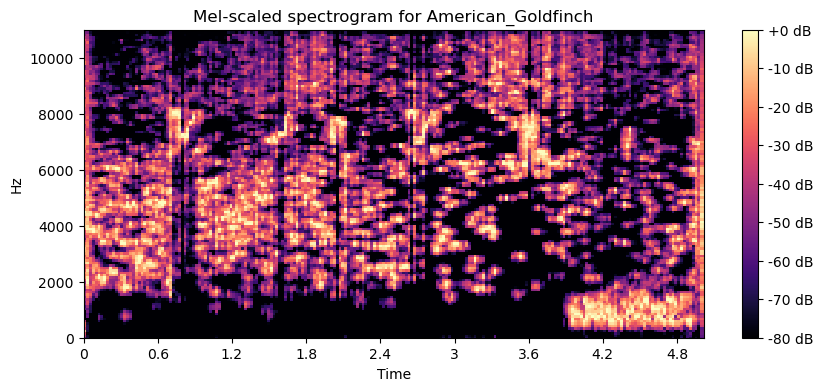

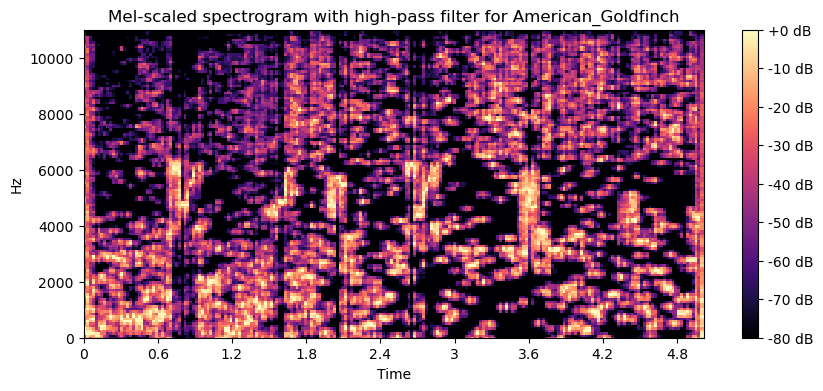

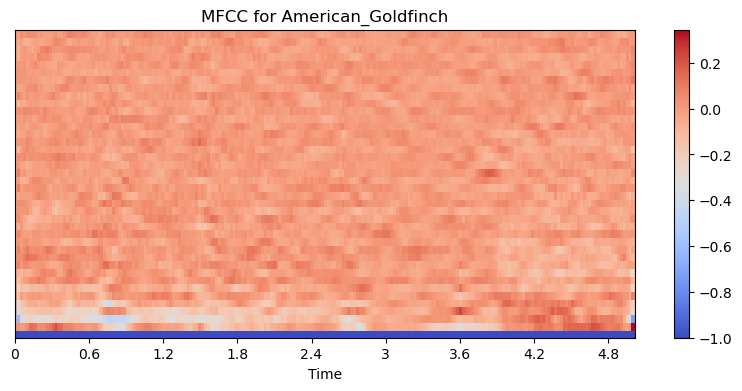

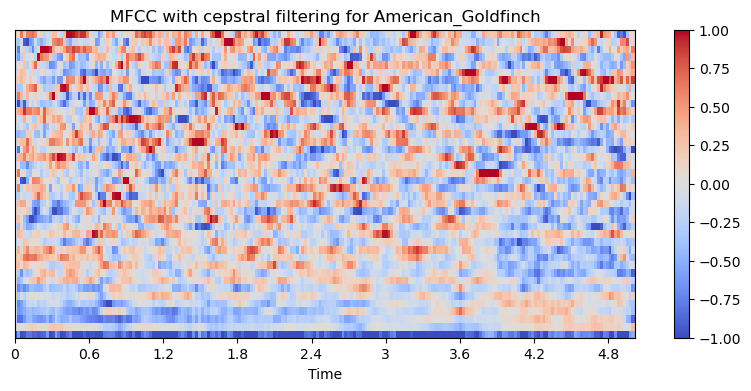

 10%|█         | 1/10 [00:04<00:40,  4.51s/it]

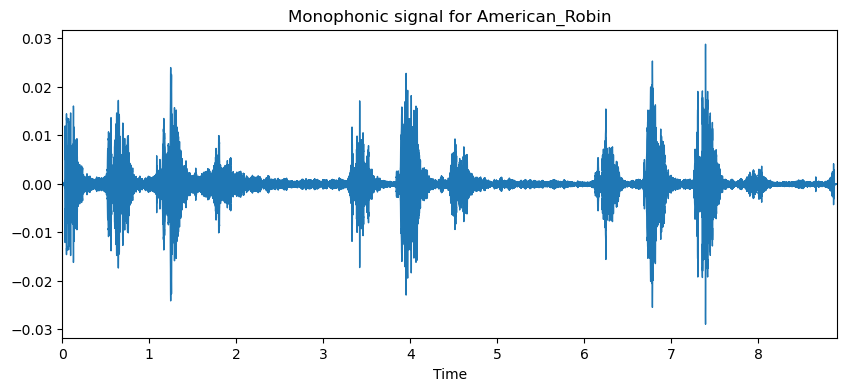

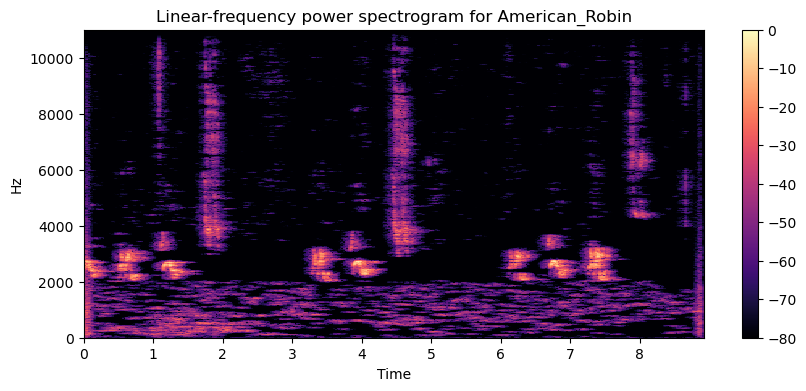

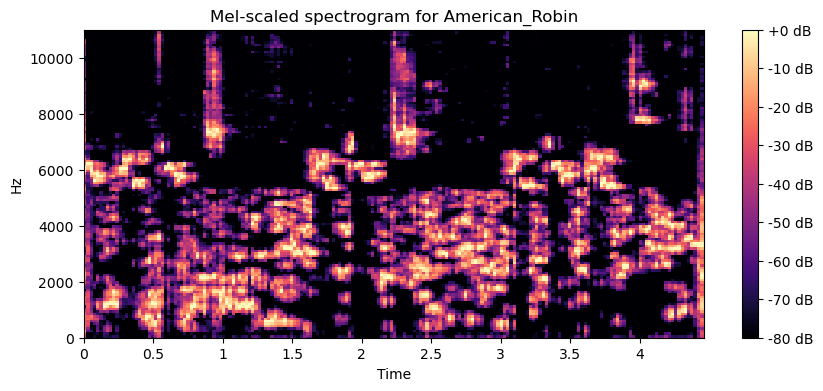

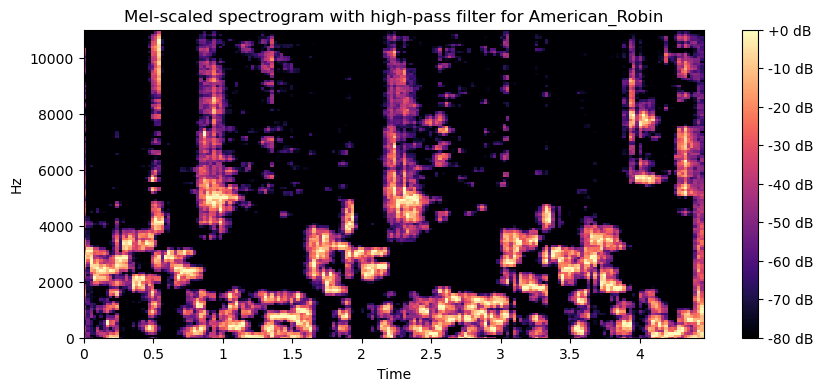

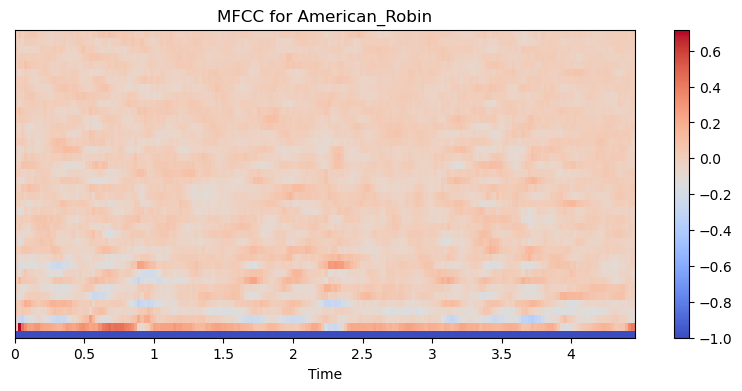

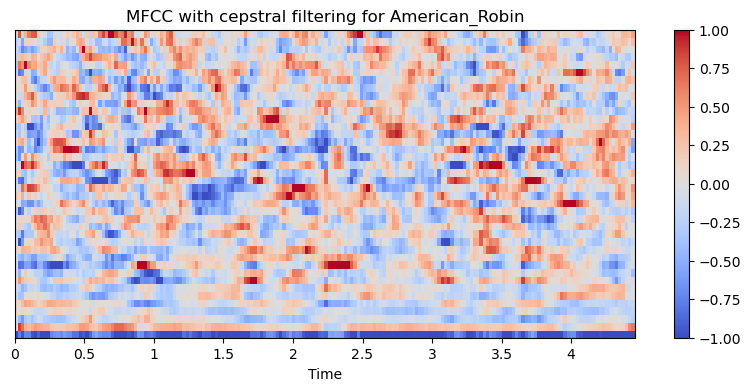

 20%|██        | 2/10 [00:08<00:35,  4.45s/it]

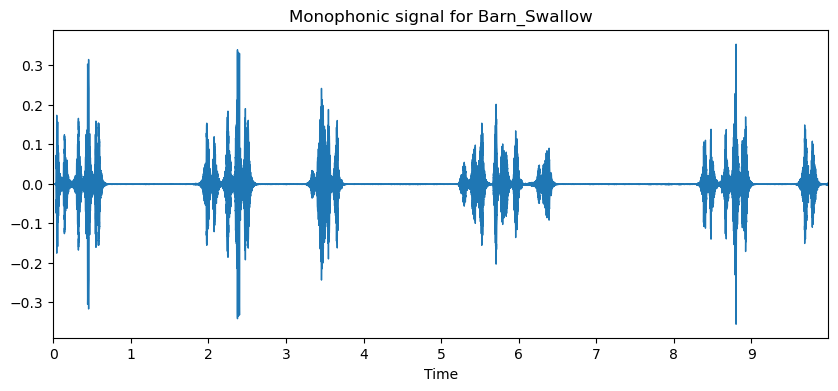

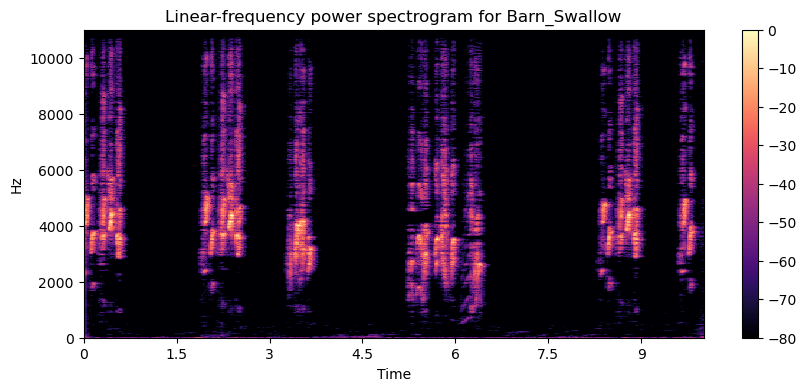

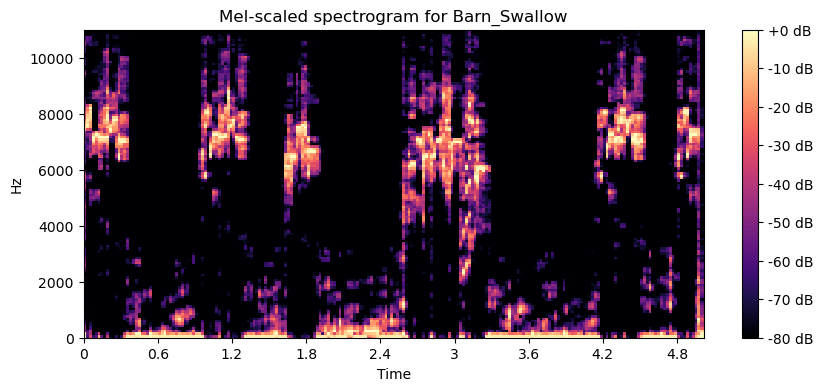

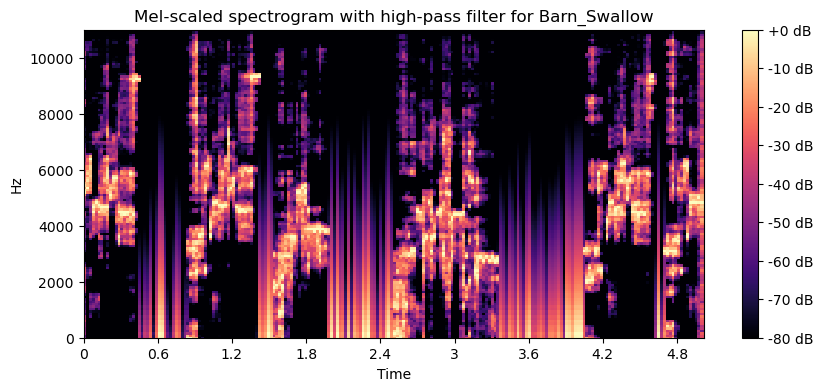

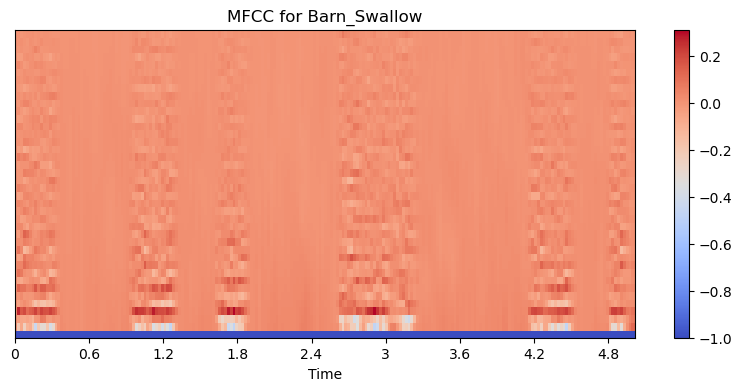

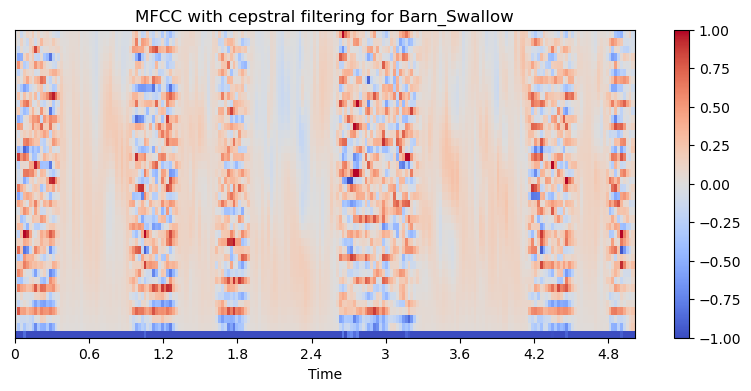

 30%|███       | 3/10 [00:13<00:31,  4.46s/it]

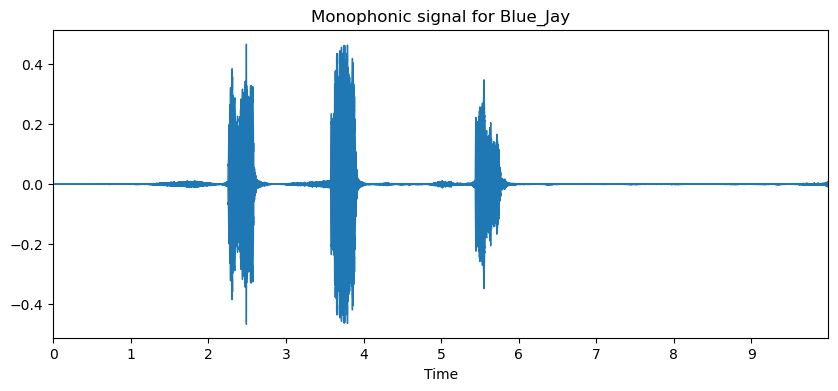

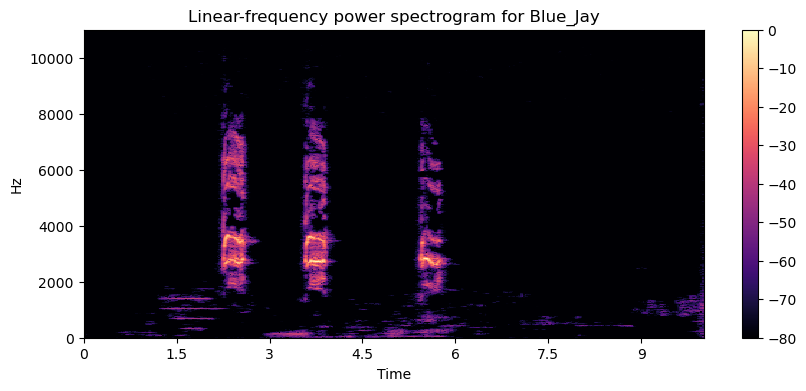

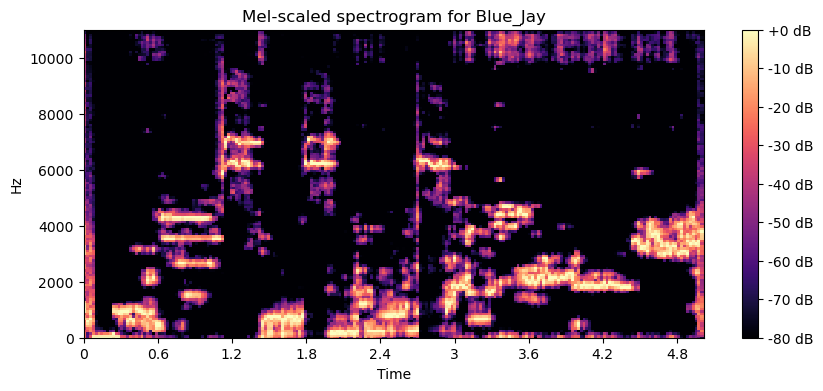

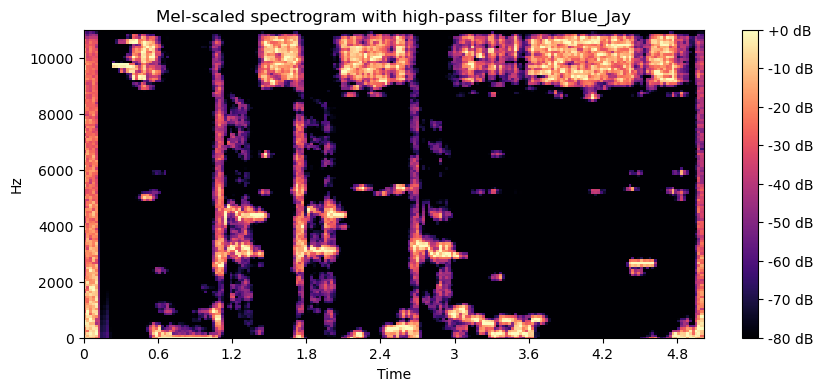

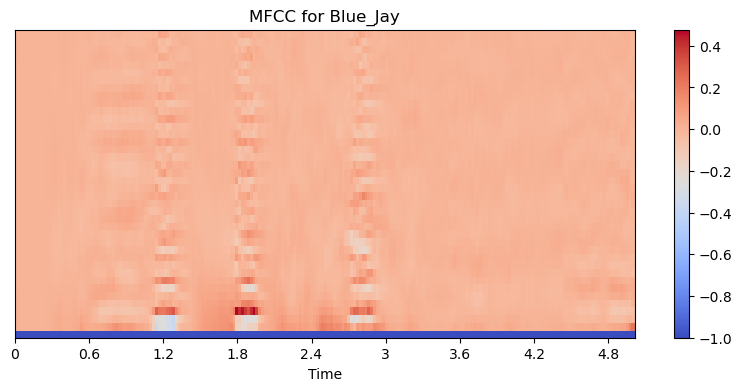

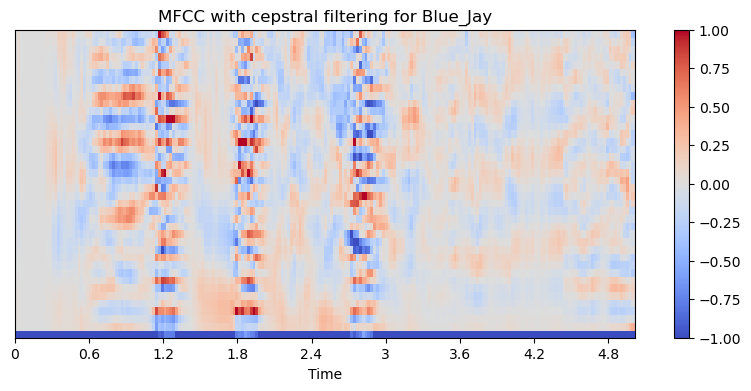

 40%|████      | 4/10 [00:17<00:26,  4.42s/it]

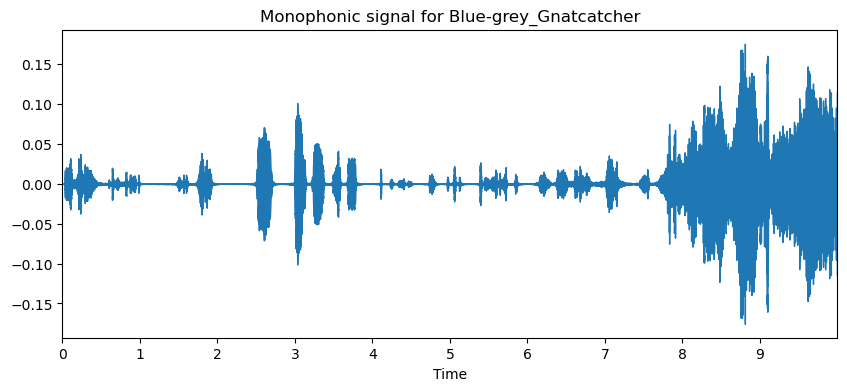

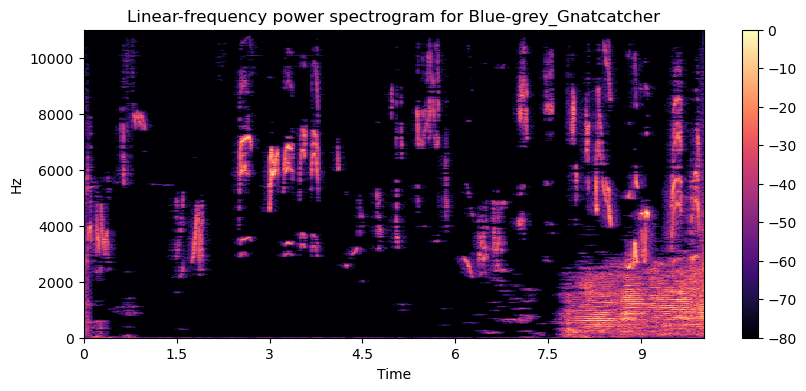

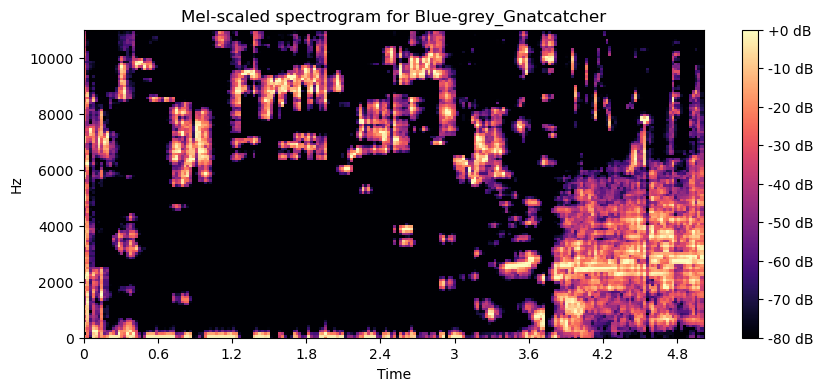

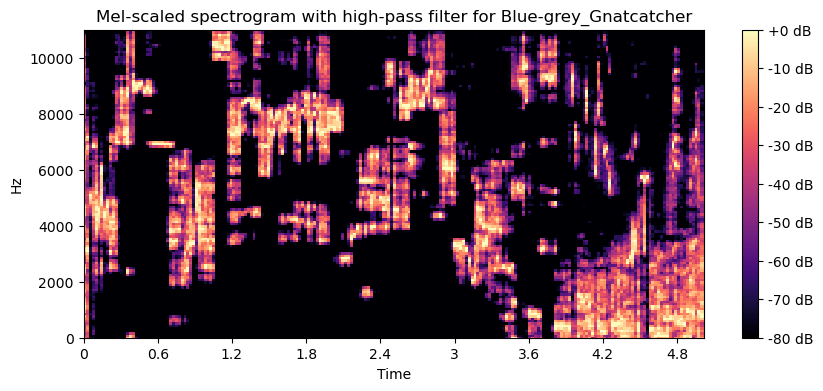

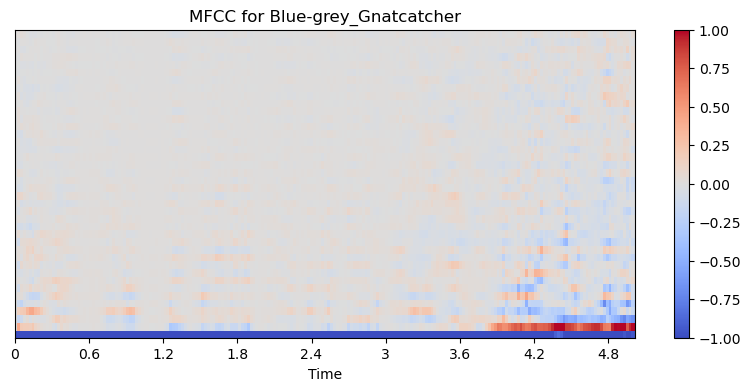

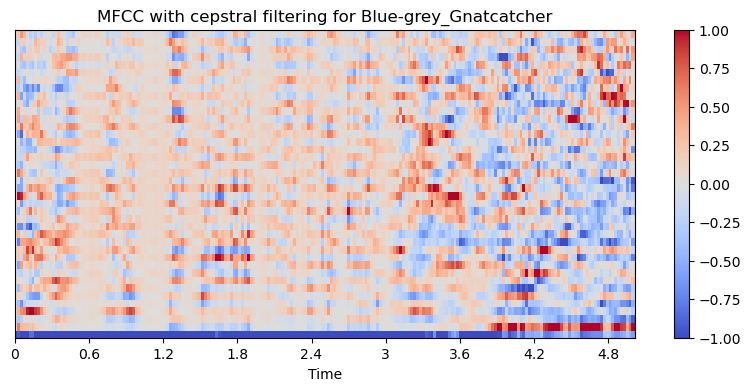

 50%|█████     | 5/10 [00:22<00:22,  4.46s/it]

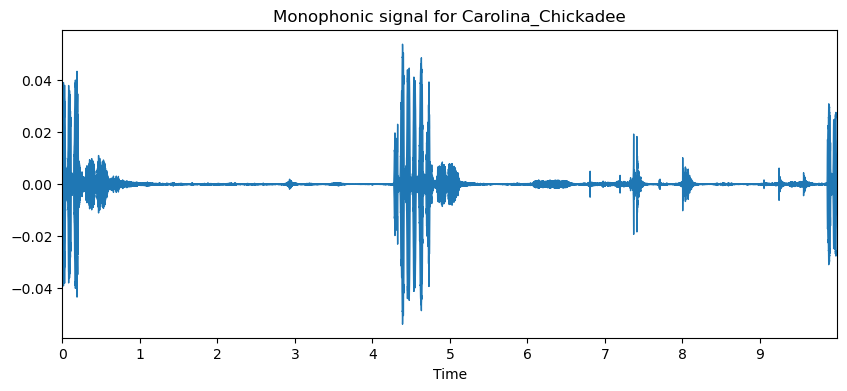

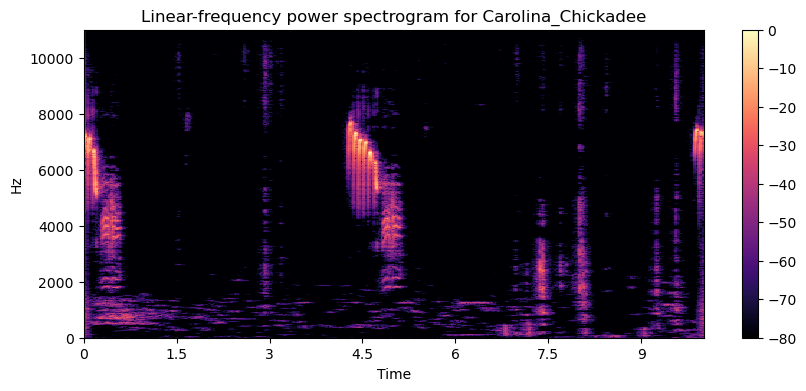

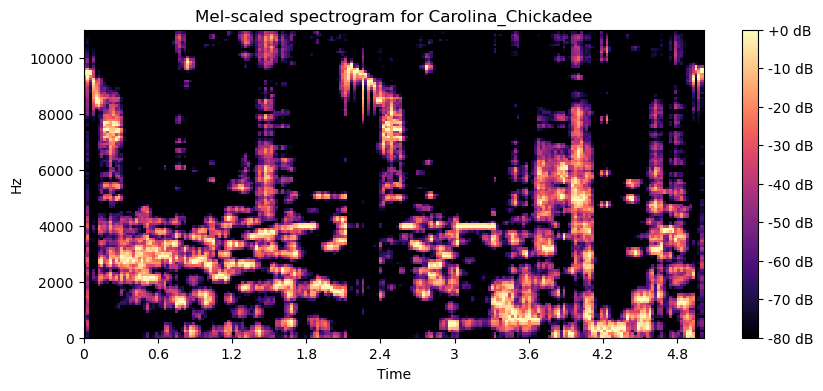

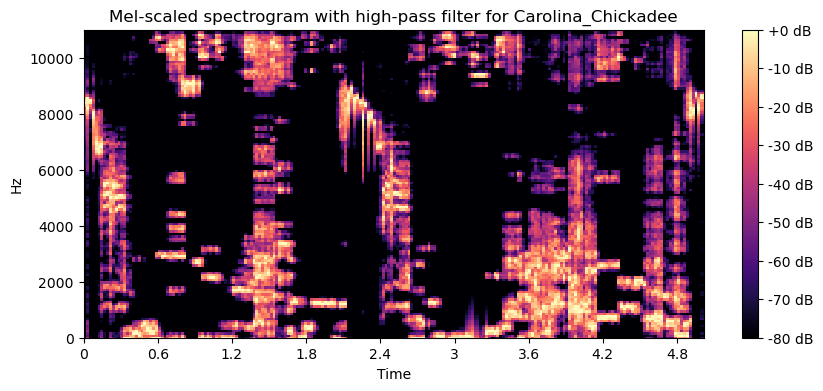

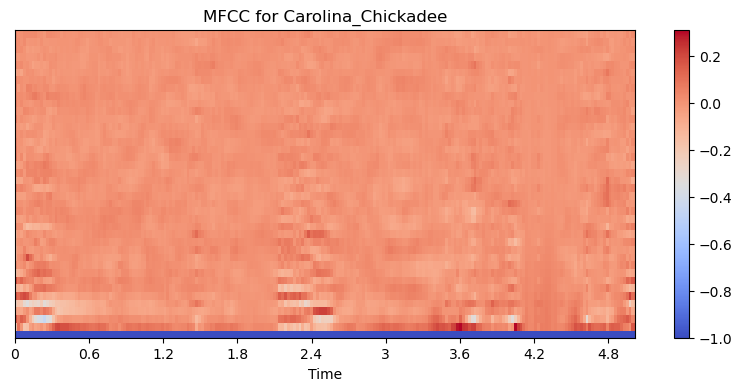

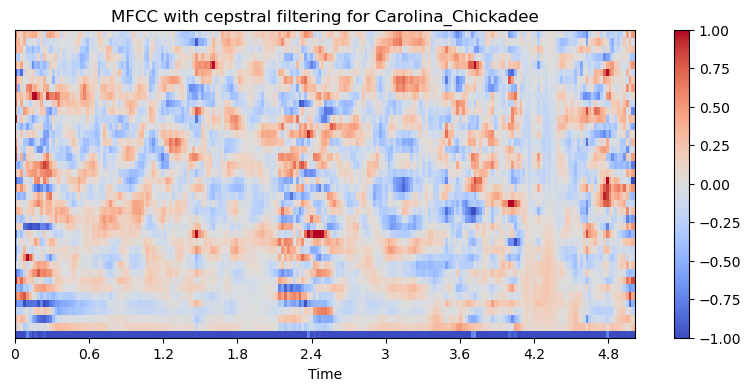

 60%|██████    | 6/10 [00:26<00:18,  4.53s/it]

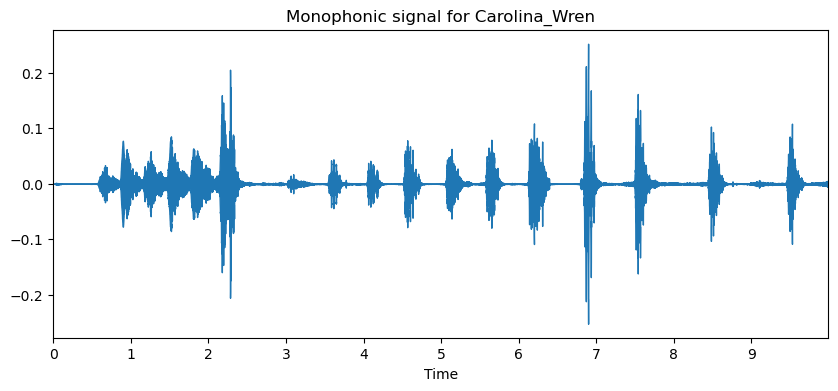

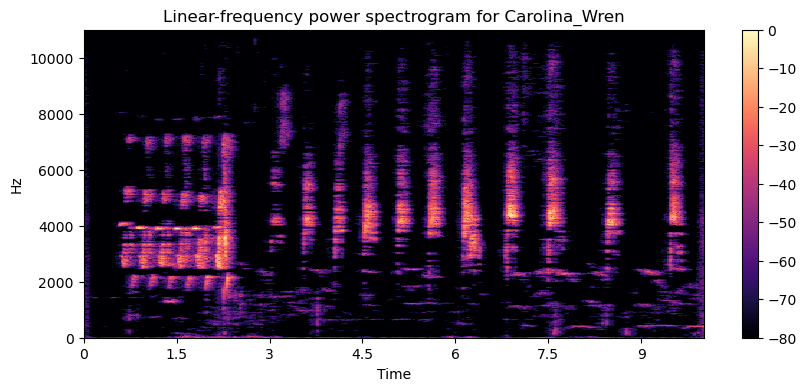

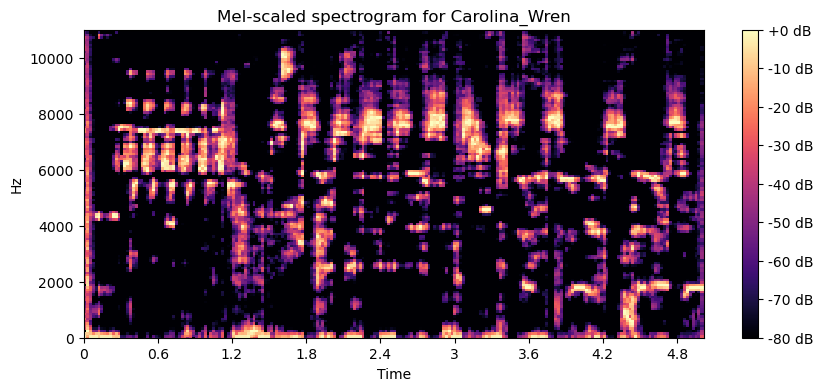

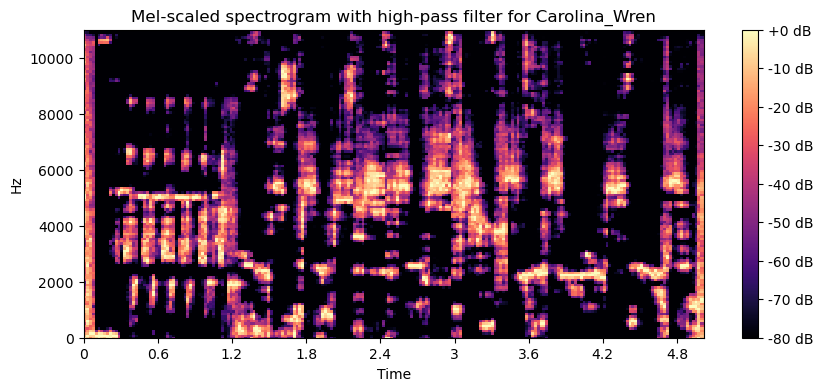

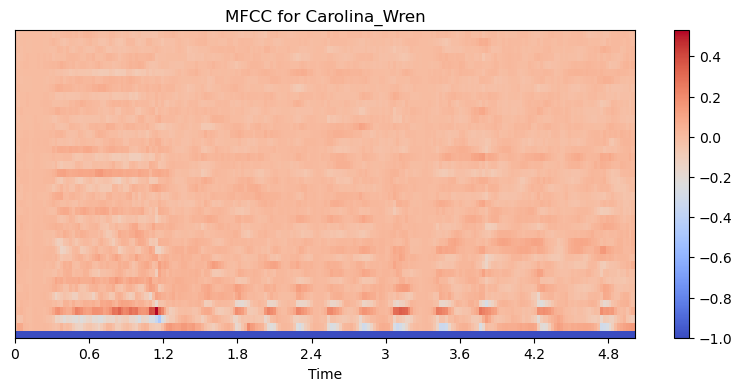

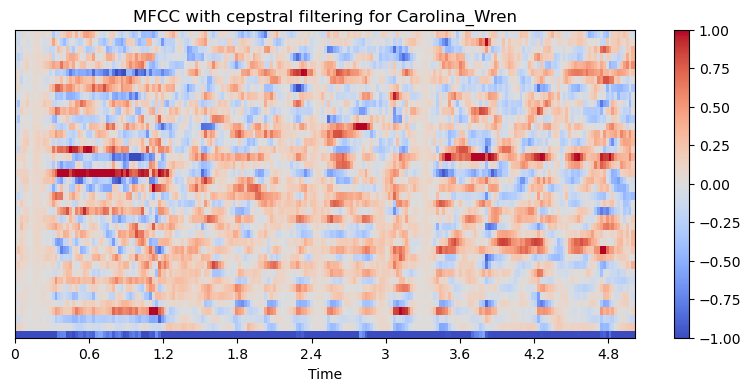

 70%|███████   | 7/10 [00:31<00:13,  4.48s/it]

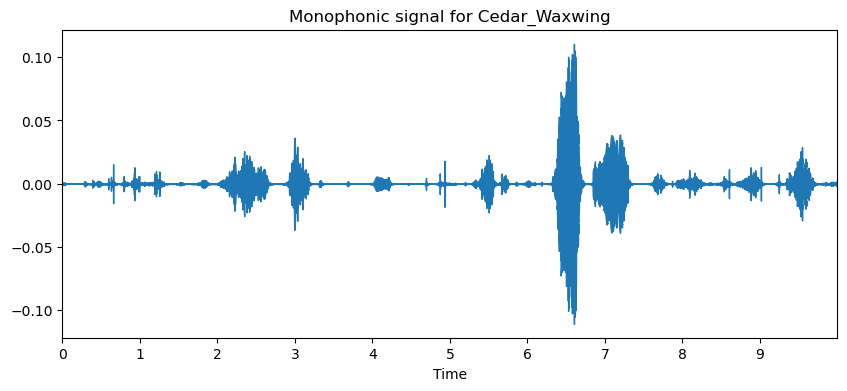

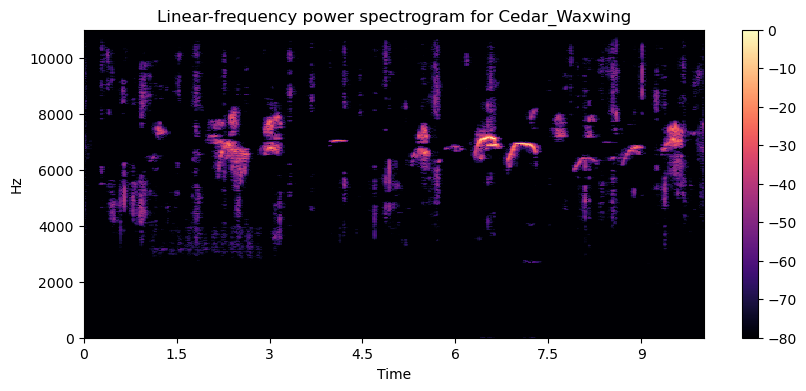

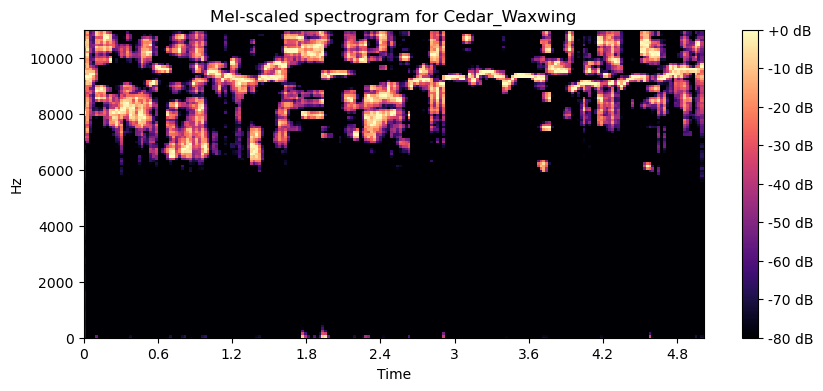

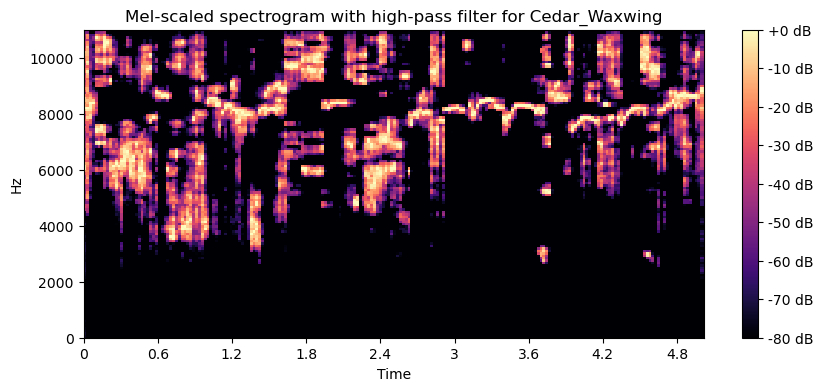

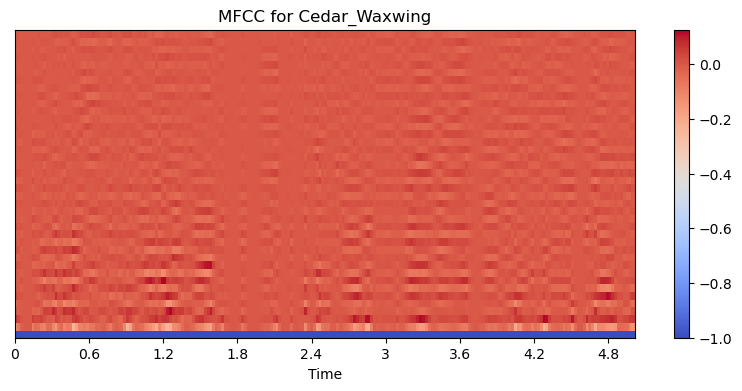

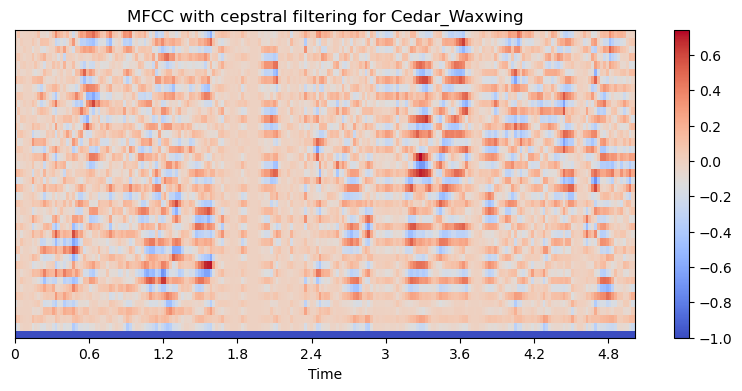

 80%|████████  | 8/10 [00:35<00:09,  4.55s/it]

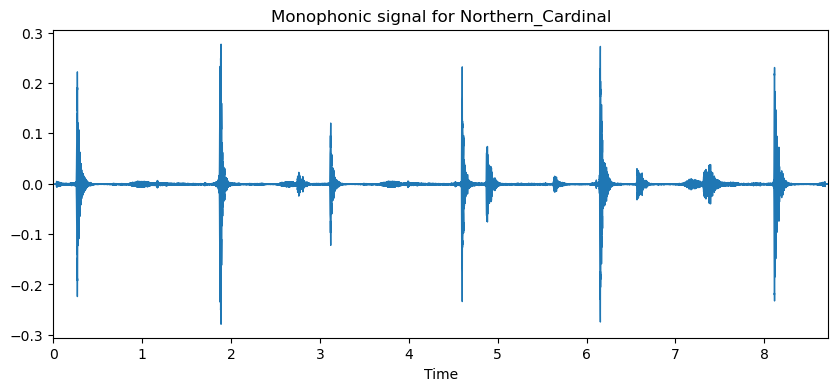

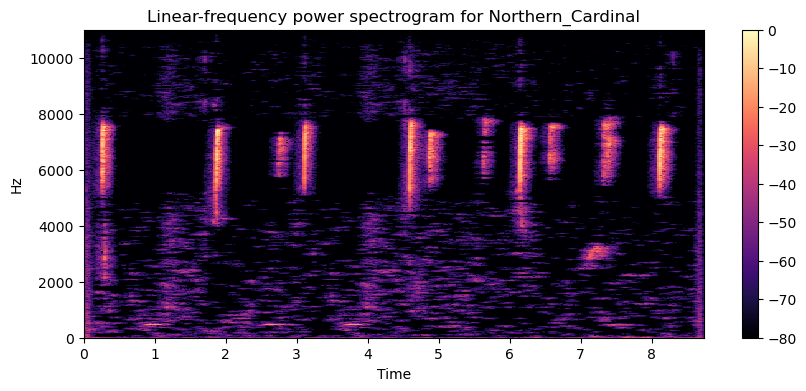

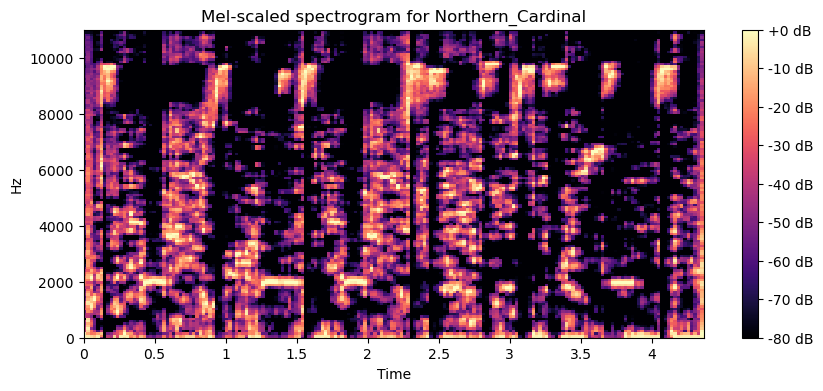

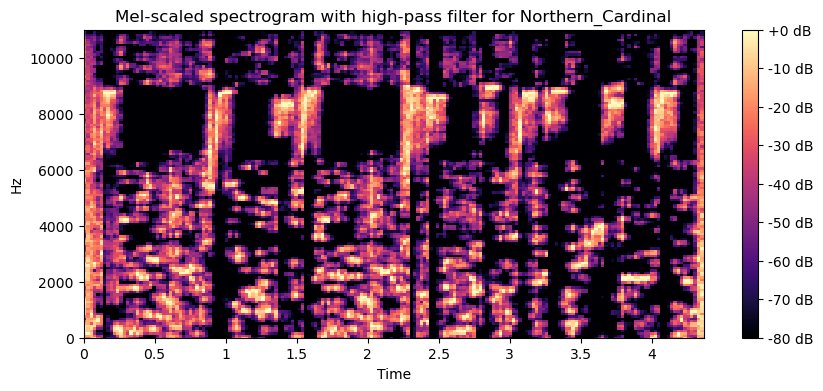

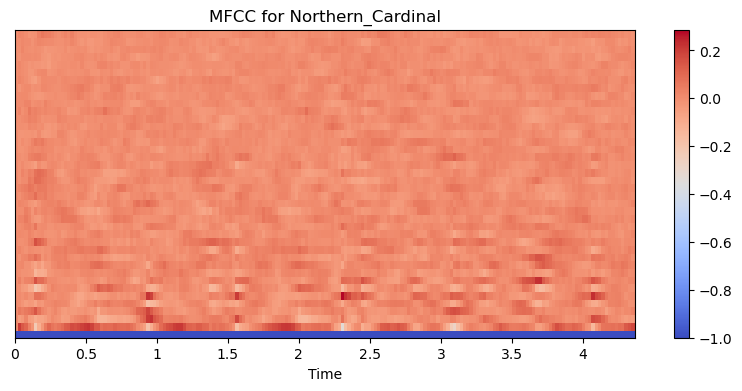

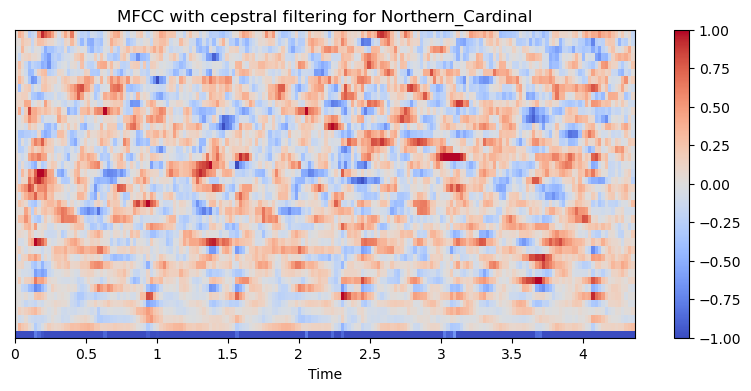

 90%|█████████ | 9/10 [00:40<00:04,  4.45s/it]

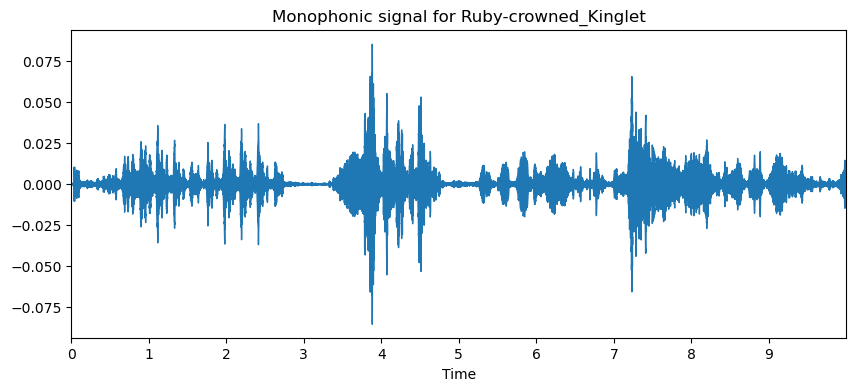

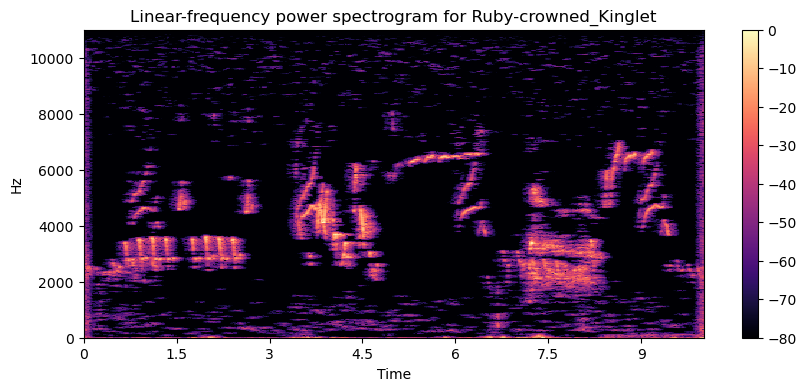

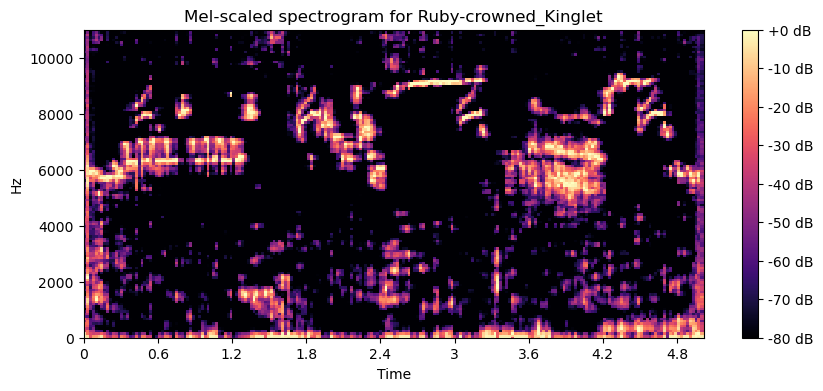

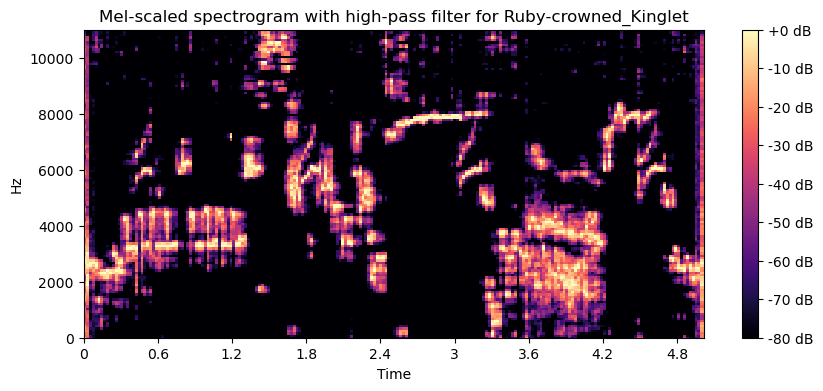

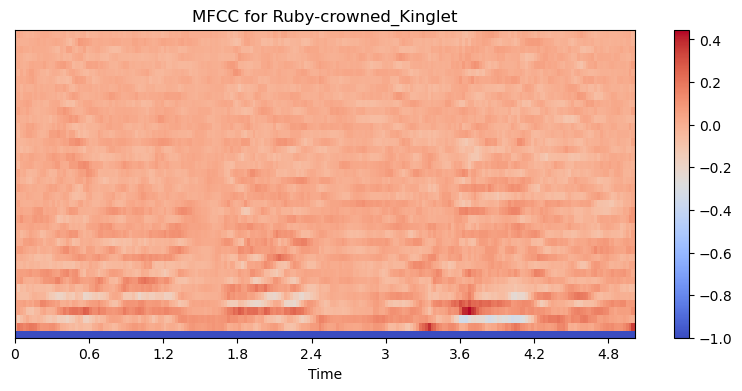

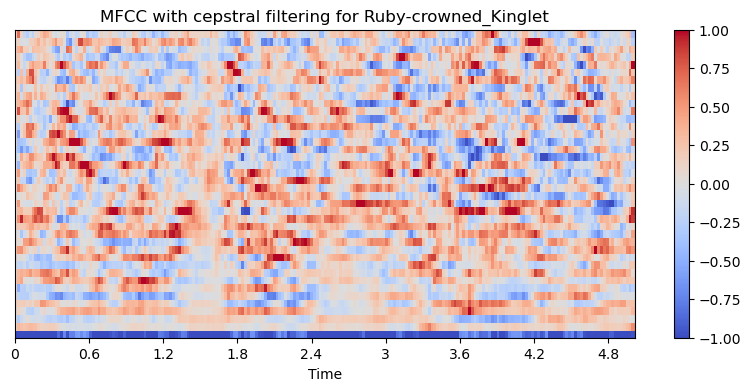

100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


In [101]:
for file in tqdm(birds_sample):
    RawSignal(file, exampleFolder)
    Feq_Spectrogram(file, exampleFolder)
    Mel_Spectrogram(file, 1024, 1024, 'hann', exampleFolder)
    Mel_Spectrogram(file, 1024, 1024, 'hann', exampleFolder,True)
    MFCC(file, 1024, 40, 1024, exampleFolder)
    MFCC(file, 1024, 40, 1024, exampleFolder, 2, True)
    
    